# Exploratory Data Analysis

The objective of this notebook is to select features for electricity 
price forecasting models by using historical data to:
1. Visualise trends and periodic behaviour
2. Investigate relationships between variables
3. Compare forecasts with actual historical data

## 1. Identify trends and periodic behaviour

### 1.1 Load datasets

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-colorblind")

base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load BMRS data (generation, demand, prices)
df_bmrs = pd.read_csv(
    os.path.join(base_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Load gas prices
df_gas = pd.read_csv(
    os.path.join(base_dir, "gas_prices.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Merge electricity data with gas prices
df_electricity = df_bmrs.merge(df_gas, on="SETTLEMENT_DATE", how="left")

# Load weather data
df_weather = pd.read_csv(
    os.path.join(base_dir, "weather_data.csv"), parse_dates=["ob_time"]
)

# Sort by date and period
df_electricity = df_electricity.sort_values(
    ["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"]
)

# Set date and period as index
df_electricity.set_index(
    ["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"], inplace=True
)

df_weather = df_weather.sort_values("ob_time")
df_weather.set_index("ob_time", inplace=True)

print(
    f"Electricity data memory usage: {np.sum(df_electricity.memory_usage()) / 10**6} MB"
)
print(
    f"Weather data memory usage: {np.sum(df_weather.memory_usage()) / 10**6} MB"
)

print("\nElectricity data columns:\n", df_electricity.columns)
print("\nWeather data columns:\n", df_weather.columns)

Electricity data memory usage: 7.89097 MB
Weather data memory usage: 5.886496 MB

Electricity data columns:
 Index(['BIOMASS', 'GAS', 'COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER',
       'INTER', 'INDO', 'ITSO', 'ELECTRICITY_PRICE', 'TRADING_VOLUME',
       'NATURAL_GAS_PRICE'],
      dtype='object')

Weather data columns:
 Index(['wind_speed', 'wind_direction', 'visibility', 'air_temperature',
       'glbl_irad_amt', 'location'],
      dtype='object')


In [2]:
df_electricity.head()

BIOMASS      GAS  COAL  OIL  NUCLEAR  \
SETTLEMENT_DATE SETTLEMENT_PERIOD                                         
2021-01-01      1                   3116.0  11268.0   0.0  0.0   5949.0   
                2                   3118.0  11526.0   0.0  0.0   5956.0   
                3                   3087.0  11240.0   0.0  0.0   5948.0   
                4                   3117.0  10365.0   0.0  0.0   5950.0   
                5                   3113.0  10020.0   0.0  0.0   5949.0   

                                   SOLAR      WIND  OTHER   INTER     INDO  \
SETTLEMENT_DATE SETTLEMENT_PERIOD                                            
2021-01-01      1                    0.0  4734.688  576.0  3428.0  28263.0   
                2                    1.0  4524.192  569.0  3572.0  28403.0   
                3                    1.0  4423.037  535.0  3570.0  27633.0   
                4                    0.0  4309.821  521.0  3568.0  26768.0   
                5                    0.0  4306.346  517.0  3512.0  25876.0   

                                      ITSO  ELECTRICITY_PRICE  TRADING_VOLUME  \
SETTLEMENT_DATE SETTLEMENT_PERIOD                                               
2021-01-01      1                  28880.0              68.54          407.30   
                2                  29018.0              69.82          601.40   
                3                  28252.0              67.42          608.00   
                4                  27625.0              65.45          579.35   
                5                  27051.0              59.44          729.40   

                                   NATURAL_GAS_PRICE  
SETTLEMENT_DATE SETTLEMENT_PERIOD                     
2021-01-01      1                             19.499  
                2                             19.499  
                3                             19.499  
                4                             19.499  
                5                             19.499

In [3]:
df_weather.head()

,wind_speed,wind_direction,visibility,air_temperature,glbl_irad_amt,location
ob_time,,,,,,
2021-01-01 00:00:00,1.028,120.0,140.0,0.9,NaN,Crosby
2021-01-01 00:00:00,6.168,320.0,3500.0,4.1,0.0,Dyce
2021-01-01 00:00:00,1.028,360.0,500.0,0.5,0.0,Heathrow
2021-01-01 01:00:00,1.028,90.0,480.0,0.5,NaN,Crosby
2021-01-01 01:00:00,6.168,310.0,4500.0,3.9,0.0,Dyce


### 1.2 Electricity prices

Plot daily mean electricity prices:

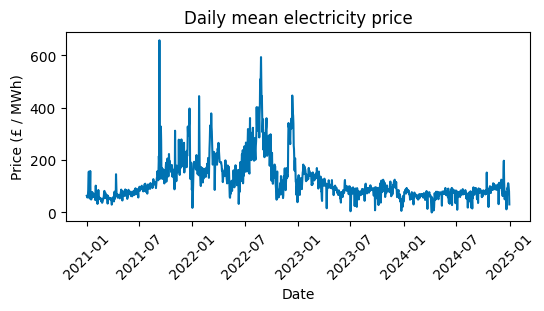

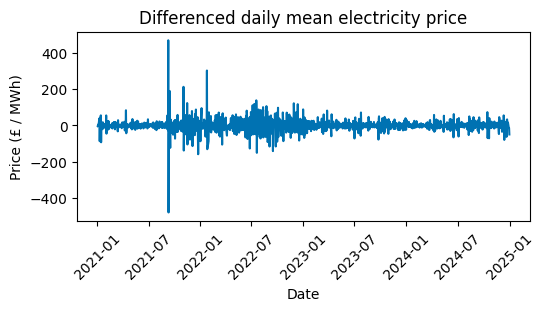

In [4]:
daily_price = df_electricity.groupby("SETTLEMENT_DATE")[
    "ELECTRICITY_PRICE"
].mean()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(daily_price)
plt.xticks(rotation=45)
ax.set_title("Daily mean electricity price")
ax.set_xlabel("Date")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(daily_price.diff())
plt.xticks(rotation=45)
ax.set_title("Differenced daily mean electricity price")
ax.set_xlabel("Date")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

Plot half-hourly electricity prices over a shorter period:

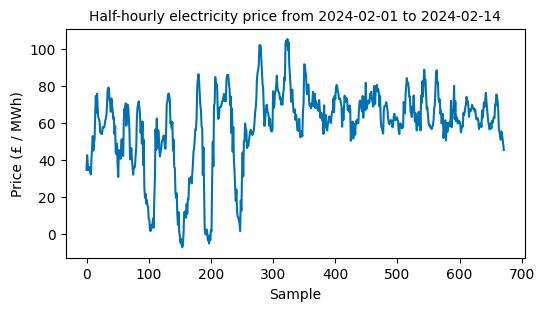

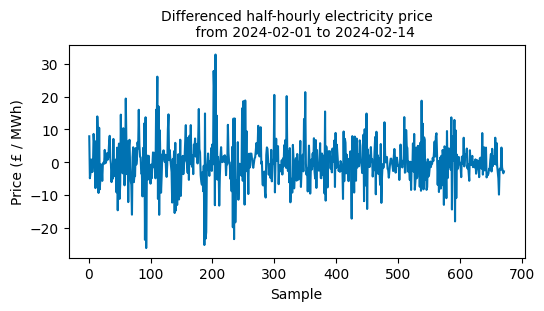

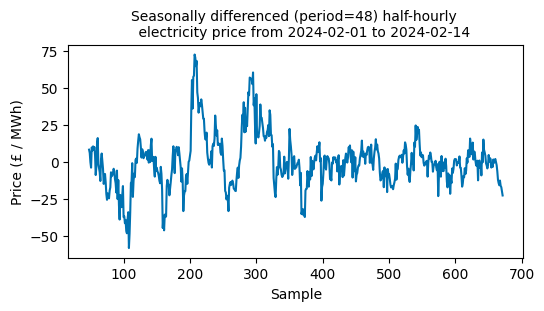

In [5]:
start_date = "2024-02-01"
end_date = "2024-02-14"

el_price = df_electricity["ELECTRICITY_PRICE"].loc[start_date:end_date]
el_price = el_price.reset_index()["ELECTRICITY_PRICE"]

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(el_price)
ax.set_title(
    f"Half-hourly electricity price from {start_date} to {end_date}",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(el_price.diff())
ax.set_title(
    f"""Differenced half-hourly electricity price
    from {start_date} to {end_date}""",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

period = 48

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(el_price.diff(period))
ax.set_title(
    f"""Seasonally differenced (period={period}) half-hourly 
    electricity price from {start_date} to {end_date}""",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

Plot price histogram:

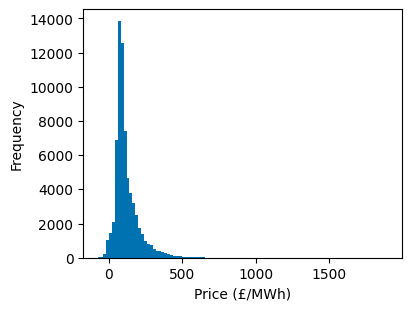

In [6]:
fig, ax = plt.subplots(figsize=(4, 3), layout="constrained")
ax.hist(df_electricity["ELECTRICITY_PRICE"], bins=100)
ax.set_xlabel("Price (£/MWh)", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
plt.show()

*Comments:*

Unsure what type of distribution this is. In any case, it is positively skewed.

Let's investigate monthly, weekly, daily and intraday price patterns:

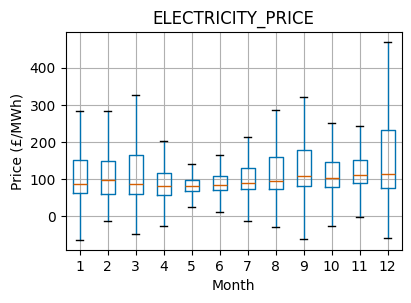

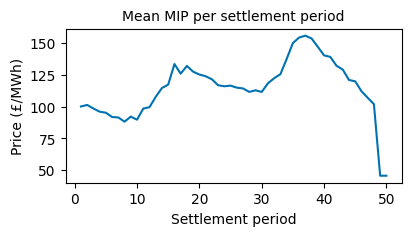

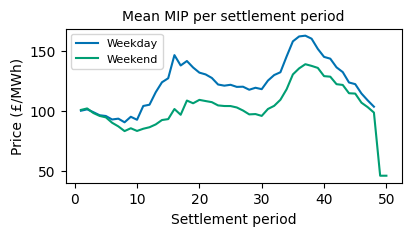

In [7]:
df = df_electricity.reset_index()

# Box plot by month (not showing outlier points)
df["MONTH"] = df["SETTLEMENT_DATE"].dt.month
fig, ax = plt.subplots(figsize=(4, 3), layout="constrained")
df.boxplot(column="ELECTRICITY_PRICE", by="MONTH", ax=ax, sym="")
ax.set_xlabel("Month", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
fig.suptitle("")
plt.show()

# Average price by settlement period
sp_avg = df.groupby(df["SETTLEMENT_PERIOD"])["ELECTRICITY_PRICE"].mean()
fig, ax = plt.subplots(figsize=(16 / 4, 9 / 4), layout="constrained")
ax.plot(sp_avg.index, sp_avg.values)
ax.set_xlabel("Settlement period", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title("Mean MIP per settlement period", fontsize=10)
plt.show()

# Average price by weekday
df["DAY_OF_WEEK"] = df["SETTLEMENT_DATE"].dt.dayofweek
df["IS_WEEKEND"] = df["DAY_OF_WEEK"] >= 5
fig, ax = plt.subplots(figsize=(16 / 4, 9 / 4), layout="constrained")
for weekend, group in df.groupby("IS_WEEKEND"):
    hourly = group.groupby(group["SETTLEMENT_PERIOD"])[
        "ELECTRICITY_PRICE"
    ].mean()
    label = "Weekend" if weekend else "Weekday"
    ax.plot(hourly.index, hourly.values, label=label)
ax.legend(loc="best", fontsize=8)
ax.set_xlabel("Settlement period", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title("Mean MIP per settlement period", fontsize=10)
plt.show()

*Comments:*
 
There are generally two peaks and two troughs in price per day. Each settlement period is 30 minutes, so the peaks are typically during the late morning hours and evening, while troughs are typically during the early morning hours and early afternoon. Weekends are cheaper than weekdays and have a much smaller morning peak than the weekdays.

Plot rolling mean and standard deviation:

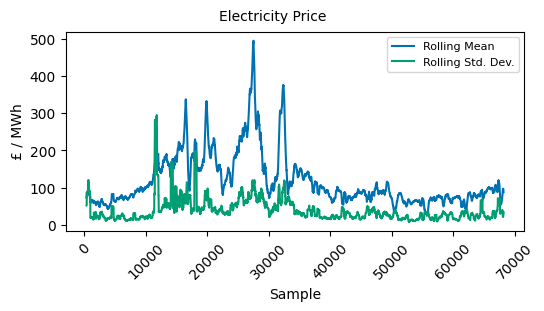

In [8]:
el_price = df["ELECTRICITY_PRICE"]
el_price_rolling_avg = el_price.rolling(48 * 7).mean().dropna()
el_price_rolling_std = el_price.rolling(48 * 7).std().dropna()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(el_price_rolling_avg, label="Rolling Mean")
ax.plot(el_price_rolling_std, label="Rolling Std. Dev.")
ax.set_xlabel("Sample")
ax.set_ylabel("£ / MWh", fontsize=10)
ax.legend(fontsize=8)
fig.suptitle("Electricity Price", fontsize=10)
plt.xticks(rotation=45)
plt.show()

### 1.3 Natural gas prices

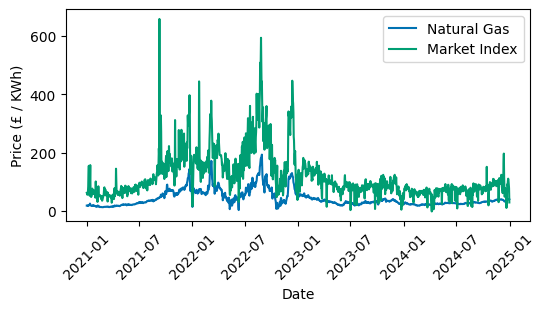

In [9]:
# drop duplicates
gas_prices = df.groupby(df["SETTLEMENT_DATE"].dt.date).first()["NATURAL_GAS_PRICE"]

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(gas_prices.index, gas_prices.values, label="Natural Gas")
ax.plot(daily_price.index, daily_price.values, label="Market Index")
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Price (£ / KWh)", fontsize=10)
ax.legend()
plt.xticks(rotation=45)
plt.show()

*Comments:*

Natural gas prices appear to be strongly correlated with electricity prices.

### 1.4 Electricity generation

Let's break down the electricity generation sources:

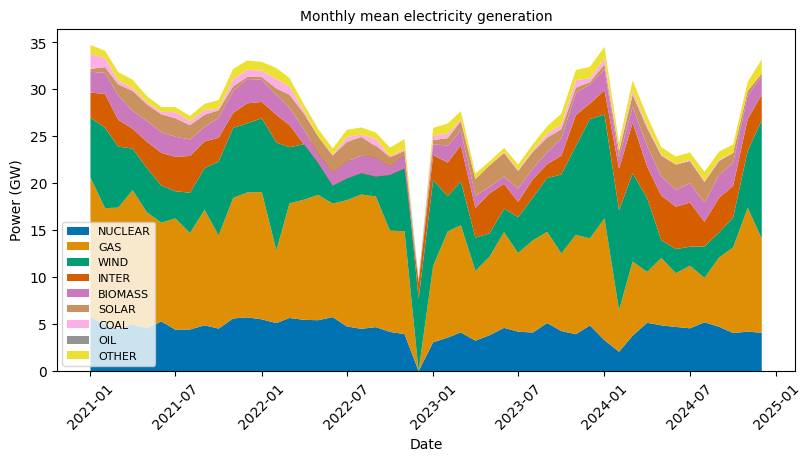

In [10]:
from matplotlib.dates import DateFormatter
import datetime

generation_types = [
    "NUCLEAR",
    "GAS",
    "WIND",
    "INTER",
    "BIOMASS",
    "SOLAR",
    "COAL",
    "OIL",
    "OTHER",
]

# Group by year-month and take mean
df["year_month"] = df["SETTLEMENT_DATE"].dt.to_period("M")
monthly_gen_by_type = df.groupby("year_month")[generation_types].mean()

# Convert period index back to datetime for plotting
monthly_gen_by_type.index = monthly_gen_by_type.index.to_timestamp()

fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="constrained")

ax.set_title("Monthly mean electricity generation", fontsize=10)
colors = sns.color_palette("colorblind", len(generation_types))

xdata = monthly_gen_by_type.index
ydata = [monthly_gen_by_type[gt] / 1000 for gt in generation_types]
ax.stackplot(xdata, ydata, labels=generation_types, colors=colors)

ax.legend(fontsize=8, loc="best")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Power (GW)", fontsize=10)
plt.xticks(rotation=45)
plt.show()

*Comments:*

Nuclear, gas and wind make up the majority of the UK's power generation.
There is some anomalous data around the end of 2022.

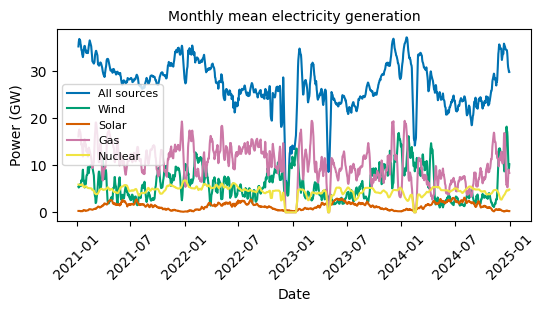

In [11]:
# compute total generation
gen_by_type = df[generation_types]
df["TOTAL_GENERATION"] = gen_by_type.sum(axis=1)

# take 7-day rolling average
cols = generation_types + ["TOTAL_GENERATION"]
daily_gen = df.groupby("SETTLEMENT_DATE")[cols].mean()
daily_gen_rolling_avg = daily_gen.rolling(window=7).mean()

# plot
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(
    daily_gen_rolling_avg["TOTAL_GENERATION"].index,
    daily_gen_rolling_avg["TOTAL_GENERATION"].values / 1000,
    label="All sources",
)
ax.plot(
    daily_gen_rolling_avg["WIND"].index,
    daily_gen_rolling_avg["WIND"].values / 1000,
    label="Wind",
)
ax.plot(
    daily_gen_rolling_avg["SOLAR"].index,
    daily_gen_rolling_avg["SOLAR"].values / 1000,
    label="Solar",
)
ax.plot(
    daily_gen_rolling_avg["GAS"].index,
    daily_gen_rolling_avg["GAS"].values / 1000,
    label="Gas",
)
ax.plot(
    daily_gen_rolling_avg["NUCLEAR"].index,
    daily_gen_rolling_avg["NUCLEAR"].values / 1000,
    label="Nuclear",
)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Power (GW)", fontsize=10)
ax.legend(fontsize=8, loc="best")
ax.set_title("Monthly mean electricity generation", fontsize=10)
plt.xticks(rotation=45)
plt.show()

Plot electricity generation breakdown for the first week in October 2023:

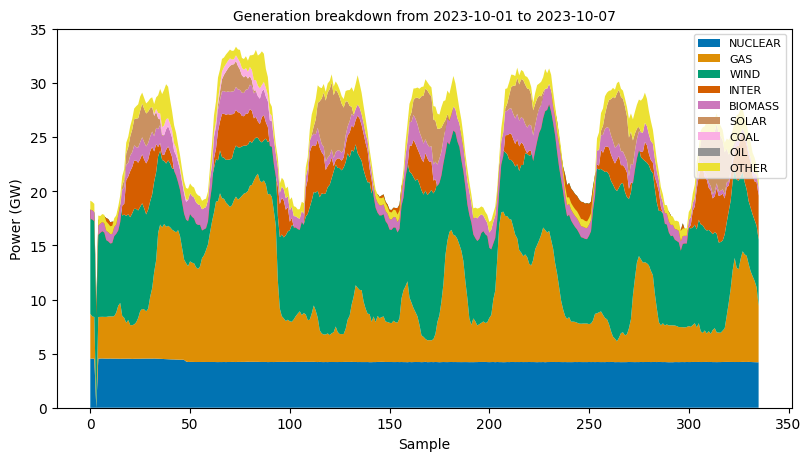

In [12]:
# select smaller date range for plotting
start_date = "2023-10-01"
end_date = "2023-10-07"
df_filtered = df_electricity.loc[start_date:end_date]
gen_by_type = df_filtered[generation_types].reset_index()

fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="constrained")
colors = sns.color_palette("colorblind", len(generation_types))
ax.stackplot(
    np.arange(len(gen_by_type)),
    [gen_by_type[gt] / 1000 for gt in generation_types],
    labels=generation_types,
    colors=colors,
)
ax.legend(fontsize=8, loc="upper right")
ax.set_xlabel("Sample", fontsize=10)
ax.set_ylabel("Power (GW)", fontsize=10)
ax.set_title(
    f"Generation breakdown from {start_date} to {end_date}",
    fontsize=10
)
plt.show()

*Comments:*

- Nuclear, gas and wind make up the majority of the energy generation
- Nuclear generation is very stable
- There are large, daily fluctuations in energy generation
- Energy from interconnectors is mostly positive, indicating that 
    imports are larger than exports
- Solar generation coincides with early peak hours
- Oil generation is neglibible
- There are clearly seasonal patterns in both wind and solar generation 
    (more solar during summers, more wind during winters).
- There are some anomalies in the generation data around the end of 2022, 
    spring 2023 and the beginning of 2024 that indicate incorrect 
    measurement or missing values for non-renewable energy sources.

In [13]:
# drop oil generation from data
df_electricity.drop(columns="OIL", inplace=True)
generation_types.remove("OIL")

### 1.5 Weather patterns

In [14]:
df_weather.columns

Index(['wind_speed', 'wind_direction', 'visibility', 'air_temperature',
       'glbl_irad_amt', 'location'],
      dtype='object')

In [15]:
# Average over locations for each 
df = df_weather.reset_index()
df_avg_locations = df.groupby("ob_time").mean(numeric_only=True).reset_index()

# Average over locations and dates
df_avg_locations_dates = (
    df_weather.groupby(df["ob_time"].dt.date)
    .mean(numeric_only=True)
    .reset_index()
)
df_avg_locations_dates.rename(columns={"ob_time": "date"}, inplace=True)
df_avg_locations_dates.set_index("date", inplace=True)

## 2. Relationships between variables

### 2.1 Spearman and Pearson correlations between variables

Merge dataframes:

In [16]:
# Merge dataframes:
# Reset index to get SETTLEMENT_DATE and SETTLEMENT_PERIOD back as columns
df_elec_temp = df_electricity.reset_index()

# Reconstruct timestamp from SETTLEMENT_DATE and SETTLEMENT_PERIOD
df_elec_temp["startTime"] = pd.to_datetime(
    df_elec_temp["SETTLEMENT_DATE"]
) + pd.to_timedelta((df_elec_temp["SETTLEMENT_PERIOD"] - 1) * 30, unit="m")

# Compute total generation
gen_by_type = df_elec_temp[generation_types]
df_elec_temp["TOTAL_GENERATION"] = gen_by_type.sum(axis=1)

# Remove timezone from weather data
df_avg_locations["ob_time"] = pd.to_datetime(
    df_avg_locations["ob_time"]
).dt.tz_localize(None)

# Rename and merge
df_tmp = df_avg_locations.rename(columns={"ob_time": "startTime"})
df_merged = df_elec_temp.merge(df_tmp, on="startTime", how="inner")

Plot relationships between variables and electricity price:

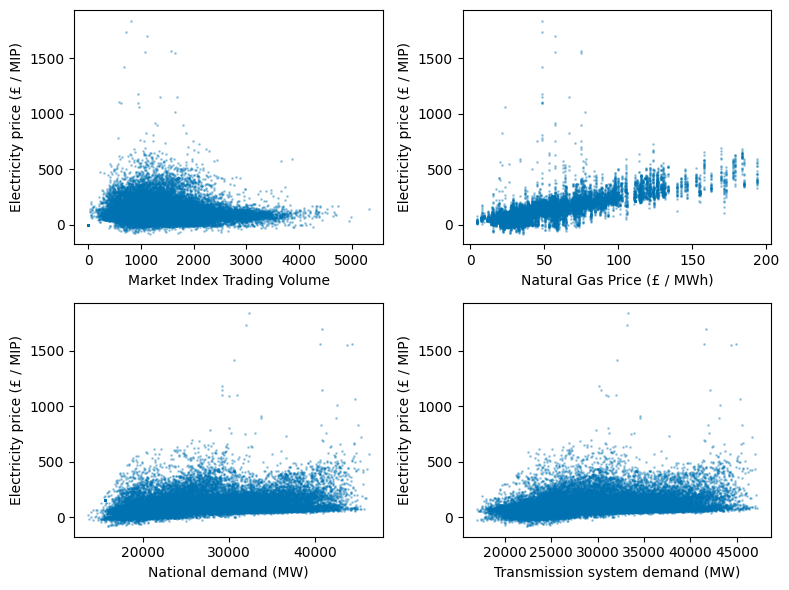

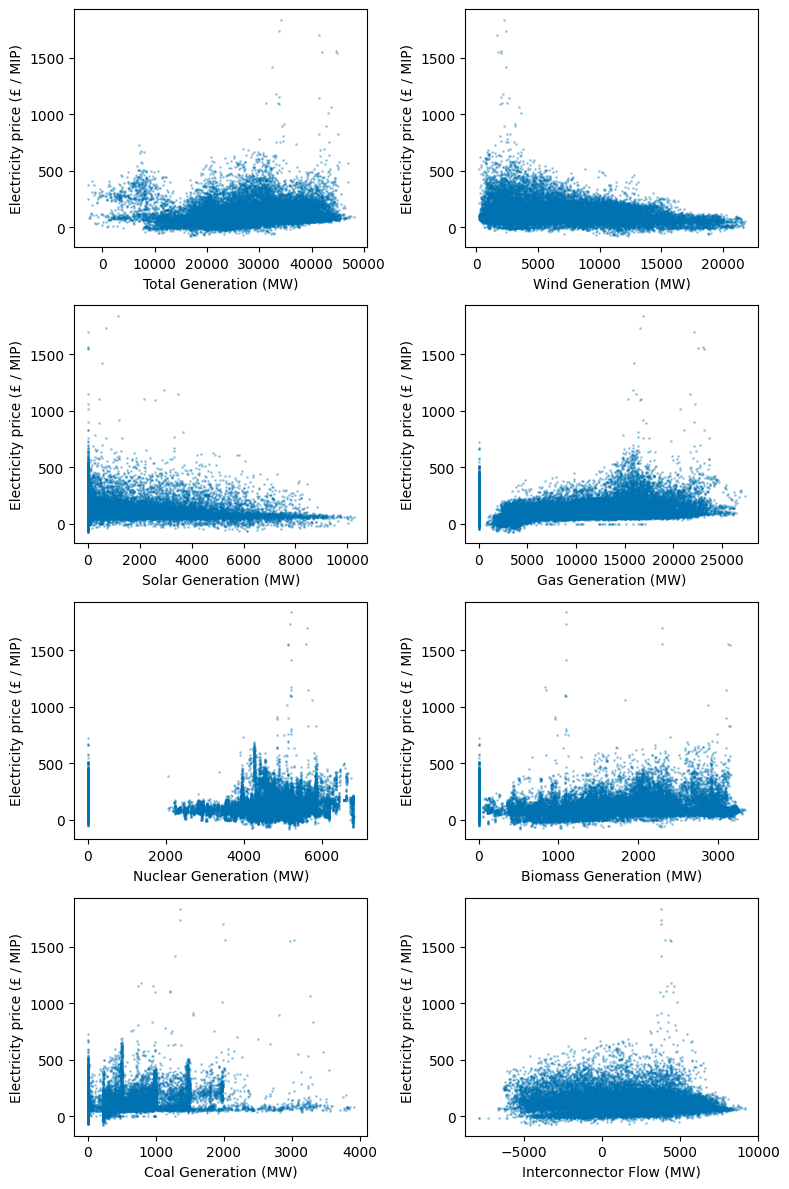

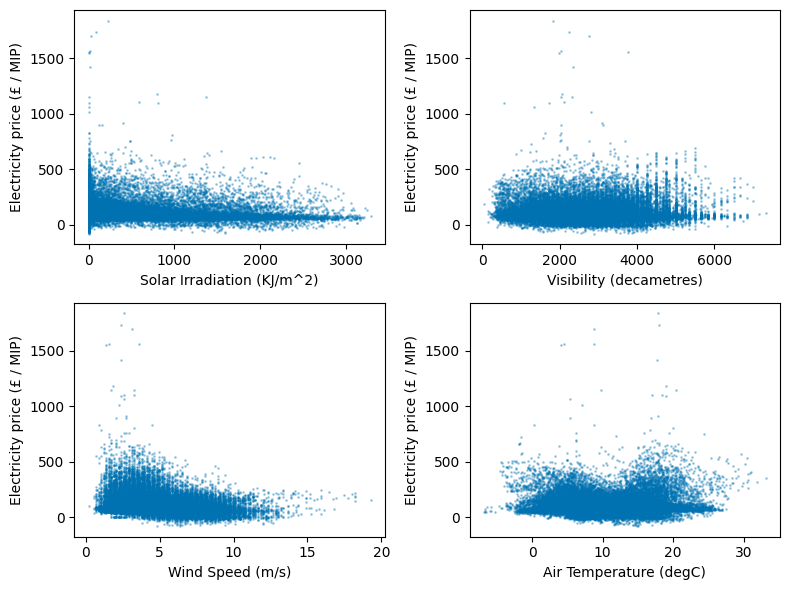

In [17]:
market_variables = {
    "TRADING_VOLUME": "Market Index Trading Volume",
    "NATURAL_GAS_PRICE": "Natural Gas Price (£ / MWh)",
    "INDO": "National demand (MW)",
    "ITSO": "Transmission system demand (MW)",
}

generation_variables = {
    "TOTAL_GENERATION": "Total Generation (MW)",
    "WIND": "Wind Generation (MW)",
    "SOLAR": "Solar Generation (MW)",
    "GAS": "Gas Generation (MW)",
    "NUCLEAR": "Nuclear Generation (MW)",
    "BIOMASS": "Biomass Generation (MW)",
    "COAL": "Coal Generation (MW)",
    "INTER": "Interconnector Flow (MW)",
}

weather_variables = {
    "glbl_irad_amt": "Solar Irradiation (KJ/m^2)",
    "visibility": "Visibility (decametres)",
    "wind_speed": "Wind Speed (m/s)",
    "air_temperature": "Air Temperature (degC)",
}

variables = market_variables | generation_variables | weather_variables

variables = {
    # market variables
    "TRADING_VOLUME": "Market Index Trading Volume",
    "NATURAL_GAS_PRICE": "Natural Gas Price",
    "INDO": "National demand",
    "ITSO": "Transmission system demand",
    # generation variables
    "TOTAL_GENERATION": "Total Generation",
    "WIND": "Wind Generation",
    "SOLAR": "Solar Generation",
    "GAS": "Gas Generation",
    "NUCLEAR": "Nuclear Generation",
    "BIOMASS": "Biomass Generation",
    "COAL": "Coal Generation",
    "INTER": "Interconnector Flow",
    # weather variables
    "glbl_irad_amt": "Solar Irradiation",
    "visibility": "Visibility",
    "wind_speed": "Wind Speed",
    "air_temperature": "Air Temperature",
}

target = "ELECTRICITY_PRICE"
target_string = "Electricity price (£ / MIP)"

fig, axes = plt.subplots(2, 2, layout="tight", figsize=(8, 6))
for ax, (var, label) in zip(axes.flat, market_variables.items()):
    ax.scatter(df_merged[var], df_merged[target], alpha=0.3, s=1)
    ax.set_xlabel(label)
    ax.set_ylabel(target_string, fontsize=10)
plt.show()

fig, axes = plt.subplots(4, 2, layout="tight", figsize=(8, 12))
for ax, (var, label) in zip(axes.flat, generation_variables.items()):
    ax.scatter(df_merged[var], df_merged[target], alpha=0.3, s=1)
    ax.set_xlabel(label)
    ax.set_ylabel(target_string, fontsize=10)
plt.show()

fig, axes = plt.subplots(2, 2, layout="tight", figsize=(8, 6))
for ax, (var, label) in zip(axes.flat, weather_variables.items()):
    ax.scatter(df_merged[var], df_merged[target], alpha=0.3, s=1)
    ax.set_xlabel(label)
    ax.set_ylabel(target_string, fontsize=10)
plt.show()

Compute correlations between different variables:

In [18]:
import scipy.stats

correlation_results = []
for var, label in variables.items():
    valid_data = df_merged[[var, target]].dropna()  # drop NaNs
    pearson_r, pearson_p = scipy.stats.pearsonr(
        valid_data[var], valid_data[target]
    )
    spearman_r, spearman_p = scipy.stats.spearmanr(
        valid_data[var], valid_data[target]
    )

    correlation_results.append(
        {
            "Variable": label,
            "Pearson": pearson_r,
            "Pearson p-value": pearson_p,
            "Spearman": spearman_r,
            "Spearman p-value": spearman_p,
        }
    )

corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values("Pearson", key=abs, ascending=False)

print("Correlations with electricity price:")
print(corr_df.to_string(index=False))

Correlations with electricity price:
                   Variable   Pearson  Pearson p-value  Spearman  Spearman p-value
          Natural Gas Price  0.798779     0.000000e+00  0.784041      0.000000e+00
             Gas Generation  0.336610     0.000000e+00  0.424506      0.000000e+00
 Transmission system demand  0.328004     0.000000e+00  0.374543      0.000000e+00
            National demand  0.298223     0.000000e+00  0.335908      0.000000e+00
            Coal Generation  0.272225     0.000000e+00  0.268996      0.000000e+00
                 Wind Speed -0.195565    3.728776e-291 -0.202435      0.000000e+00
        Interconnector Flow -0.187638    8.734908e-268 -0.186029     3.599756e-263
            Wind Generation -0.160915    1.428284e-196 -0.110517      3.874627e-93
Market Index Trading Volume -0.129213    6.969187e-127 -0.127192     5.637254e-123
           Total Generation  0.114565    5.465571e-100  0.192767     8.651019e-283
           Solar Generation -0.068536     8.553338

Visualise correlations:

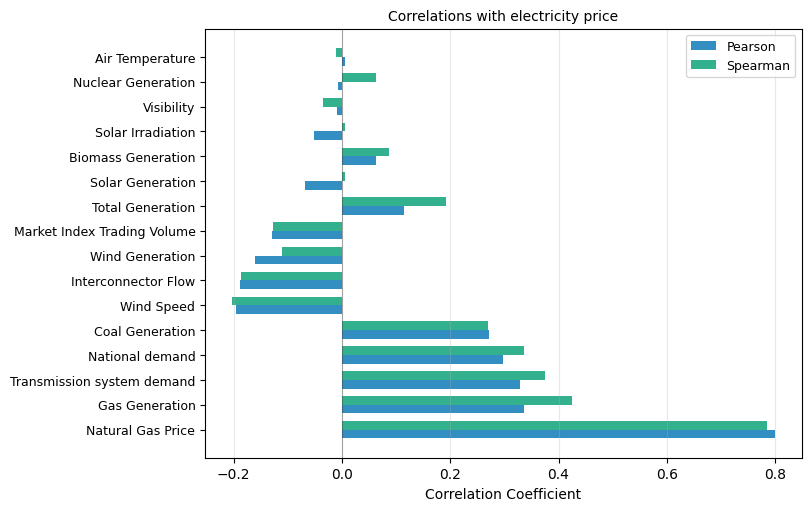

In [19]:
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
x = np.arange(len(corr_df))
width = 0.35
bars1 = ax.barh(
    x - width / 2, corr_df["Pearson"], width, label="Pearson", alpha=0.8
)
bars2 = ax.barh(
    x + width / 2, corr_df["Spearman"], width, label="Spearman", alpha=0.8
)
ax.set_yticks(x)
ax.set_yticklabels(corr_df["Variable"], fontsize=9)
ax.set_xlabel("Correlation Coefficient", fontsize=10)
ax.set_title("Correlations with electricity price", fontsize=10)
ax.legend(fontsize=9)
ax.axvline(x=0, color="black", linewidth=0.8, linestyle="-", alpha=0.3)
ax.grid(axis="x", alpha=0.3)

plt.show()

### 2.2 Time-lagged correlations

Autocorrelation of market index prices:

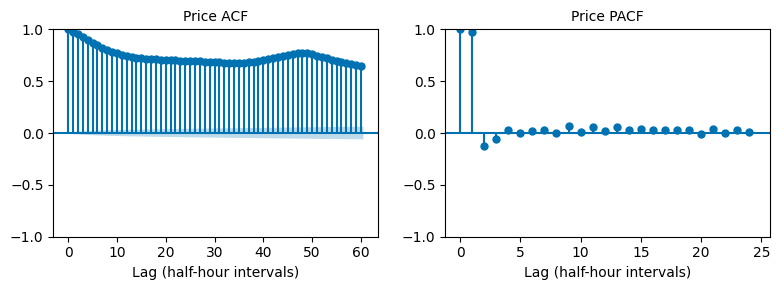

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

el_price = df_electricity["ELECTRICITY_PRICE"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(el_price, lags=60, ax=ax1)
ax1.set_title("Price ACF", fontsize=10)
ax1.set_xlabel("Lag (half-hour intervals)", fontsize=10)
plot_pacf(el_price, lags=24, ax=ax2)
ax2.set_title("Price PACF", fontsize=10)
ax2.set_xlabel("Lag (half-hour intervals)", fontsize=10)
plt.show()

The ACF function does not decay much. Let's try to difference it and see what the effect is:

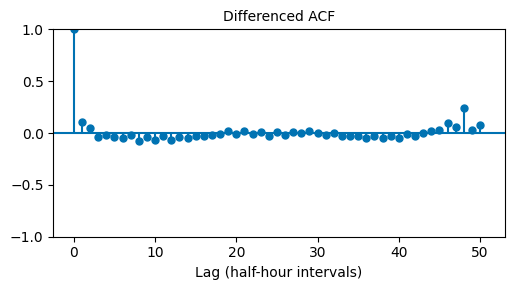

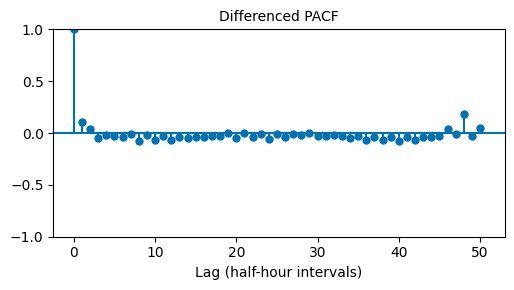

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

el_price = df_electricity["ELECTRICITY_PRICE"]
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
plot_acf(el_price.diff(1).dropna(), lags=50, ax=ax)
ax.set_title("Differenced ACF", fontsize=10)
ax.set_xlabel("Lag (half-hour intervals)", fontsize=10)
plt.show()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
plot_pacf(el_price.diff(1).dropna(), lags=50, ax=ax)
ax.set_title("Differenced PACF", fontsize=10)
ax.set_xlabel("Lag (half-hour intervals)", fontsize=10)
plt.show()

## 3. Forecast Data

Load forecast data:

In [22]:
import os

path = os.path.join(
    os.path.dirname(os.getcwd()), "data", "processed", "neso_forecasts.csv"
)
df_forecast = pd.read_csv(path, parse_dates=["SETTLEMENT_DATE"])
df_forecast.head()

,DEMAND_FORECAST,SETTLEMENT_DATE,SETTLEMENT_PERIOD,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY,WIND_CAPACITY,WIND_FORECAST
0,26622.0,2021-01-02,1,879.0,6527.0,0.0,13082.0,15729.0,2383.0
1,26229.0,2021-01-02,2,867.0,6527.0,0.0,13082.0,15729.0,2382.0
2,25836.0,2021-01-02,3,867.0,6527.0,0.0,13082.0,15729.0,2398.0
3,25443.0,2021-01-02,4,863.0,6527.0,0.0,13082.0,15729.0,2429.0
4,25050.0,2021-01-02,5,863.0,6527.0,0.0,13082.0,15729.0,2474.0


Plot demand snapshot:

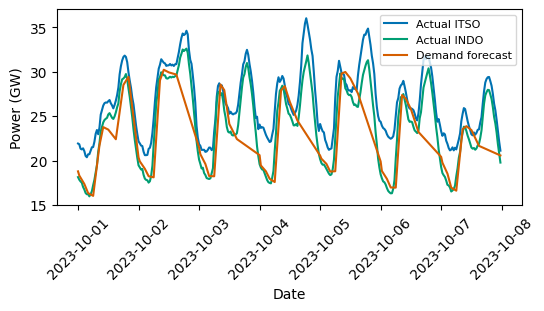

In [23]:
# Reset index to access SETTLEMENT_DATE and SETTLEMENT_PERIOD as columns
df_actual = df_electricity.reset_index()
df_forecast_temp = df_forecast.copy()

# Get snapshot
start_date = pd.Timestamp("2023-10-01")
end_date = pd.Timestamp("2023-10-07")
mask_actual = (df_actual["SETTLEMENT_DATE"] >= start_date) & (
    df_actual["SETTLEMENT_DATE"] <= end_date
)
mask_forecast = (df_forecast_temp["SETTLEMENT_DATE"] >= start_date) & (
    df_forecast_temp["SETTLEMENT_DATE"] <= end_date
)
df_actual_snap = df_actual[mask_actual].copy()
df_forecast_snap = df_forecast_temp[mask_forecast].copy()

# Create datetime from settlement date and period
# Settlement periods are 1-48 for half-hourly intervals
df_actual_snap["datetime"] = df_actual_snap[
    "SETTLEMENT_DATE"
] + pd.to_timedelta((df_actual_snap["SETTLEMENT_PERIOD"] - 1) * 30, unit="m")
df_forecast_snap["datetime"] = df_forecast_snap[
    "SETTLEMENT_DATE"
] + pd.to_timedelta((df_forecast_snap["SETTLEMENT_PERIOD"] - 1) * 30, unit="m")

# Plot
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(
    df_actual_snap["datetime"],
    df_actual_snap["ITSO"] / 1000,
    label="Actual ITSO",
)
ax.plot(
    df_actual_snap["datetime"],
    df_actual_snap["INDO"] / 1000,
    label="Actual INDO",
)
ax.plot(
    df_forecast_snap["datetime"],
    df_forecast_snap["DEMAND_FORECAST"] / 1000,
    label="Demand forecast",
)
ax.legend(fontsize=8)
plt.xticks(rotation=45)
ax.set_ylabel("Power (GW)", fontsize=10)
ax.set_xlabel("Date", fontsize=10)
plt.show()

*Comments:*

The demand forecast appears to follow the actual initial national demand outturn (INDO) reasonably well.

Plot generation snapshot:

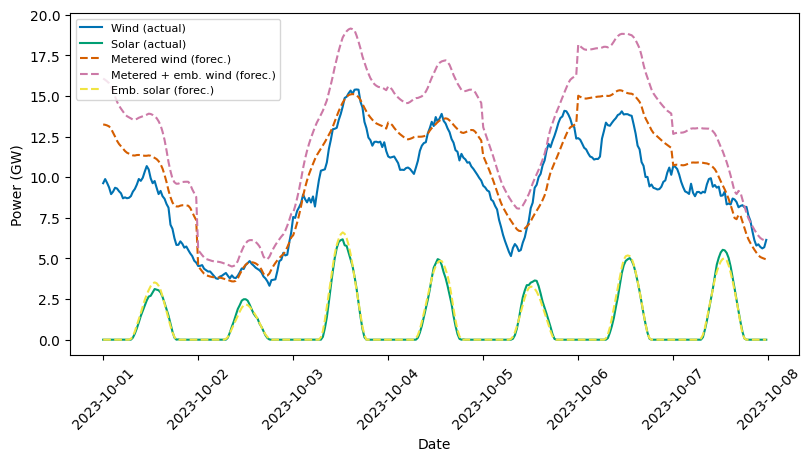

In [24]:
wind_total_forecast = (
    df_forecast_snap["WIND_FORECAST"]
    + df_forecast_snap["EMBEDDED_WIND_FORECAST"]
)
wind_metered_forecast = df_forecast_snap["WIND_FORECAST"]
solar_forecast = df_forecast_snap["EMBEDDED_SOLAR_FORECAST"]

fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="constrained")
ax.plot(
    df_actual_snap["datetime"],
    df_actual_snap["WIND"] / 1000,
    label="Wind (actual)",
)
ax.plot(
    df_actual_snap["datetime"],
    df_actual_snap["SOLAR"] / 1000,
    label="Solar (actual)",
)
ax.plot(
    df_forecast_snap["datetime"],
    wind_metered_forecast / 1000,
    ls="--",
    label="Metered wind (forec.)",
)
ax.plot(
    df_forecast_snap["datetime"],
    wind_total_forecast / 1000,
    ls="--",
    label="Metered + emb. wind (forec.)",
)
ax.plot(
    df_forecast_snap["datetime"],
    solar_forecast / 1000,
    ls="--",
    label="Emb. solar (forec.)",
)
ax.legend(fontsize=8)
plt.xticks(rotation=45)
ax.set_ylabel("Power (GW)", fontsize=10)
ax.set_xlabel("Date", fontsize=10)
plt.show()

*Comments:*

This suggests that the embedded wind generation is not included directly
in the electricity generation data and is instead an indirect effect in
demand suppression. Solar generation is accurately predicted while wind
forecasts have lower accuracy.